# Stage 11 Homework — Evaluation & Risk Communication
In the lecture, we learned **parametric vs bootstrap CIs**, **scenario sensitivity**, and **subgroup checks**.
Now, you will adapt those methods to your dataset and produce assumption-aware results.

In [1]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
np.random.seed(111)
plt.rcParams['figure.figsize'] = (8,5)

## Load Data (provided or synthetic fallback)

In [11]:
from pathlib import Path
import pandas as pd
import numpy as np

data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

csv_path = data_dir / 'data_stage11_eval_risk.csv'

if csv_path.exists():
    try:
        df = pd.read_csv(csv_path, parse_dates=['date'])
    except ValueError as e:
        print(f"Error reading CSV: {e}\nRegenerating synthetic data...")
        regenerate = True
    else:
        regenerate = False
else:
    regenerate = True

if regenerate:
    n = 180
    dates = pd.date_range('2022-06-01', periods=n, freq='D')
    seg = np.random.choice(['A','B','C'], size=n, p=[0.5,0.3,0.2])
    x = np.linspace(0, 9, n) + np.random.normal(0, 0.7, n)
    y = 2.1 * x + 0.8 + np.random.standard_t(df=3, size=n) * 1.1
    x[np.random.choice(np.arange(n), size=round(0.05*n), replace=False)] = np.nan
    df = pd.DataFrame({'date': dates, 'segment': seg, 'x_feature': x, 'y_target': y})
    df.to_csv(csv_path, index=False)

df.head(20)


,date,segment,x_feature,y_target
0,2022-06-01,B,0.547868,2.107524
1,2022-06-02,A,0.974480,2.209111
2,2022-06-03,A,-0.012991,0.867315
3,2022-06-04,B,-1.012503,-1.741932
4,2022-06-05,A,0.642399,1.615007
5,2022-06-06,A,-0.026538,-0.138586
6,2022-06-07,A,-0.179315,-1.722645
7,2022-06-08,A,-0.329349,-2.274029
8,2022-06-09,A,-0.657426,-1.178251
9,2022-06-10,A,0.445962,1.497907


## Helper Functions (complete or modify as needed)

In [3]:
def mean_impute(a: np.ndarray) -> np.ndarray:
    m = np.nanmean(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

def median_impute(a: np.ndarray) -> np.ndarray:
    m = np.nanmedian(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

class SimpleLinReg:
    def fit(self, X, y):
        X1 = np.c_[np.ones(len(X)), X.ravel()]
        beta = np.linalg.pinv(X1) @ y
        self.intercept_, self.coef_ = float(beta[0]), np.array([float(beta[1])])
        return self
    def predict(self, X):
        return self.intercept_ + self.coef_[0] * X.ravel()

def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def bootstrap_metric(y_true, y_pred, fn, n_boot=500, seed=111, alpha=0.05):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(y_true))
    stats = []
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        stats.append(fn(y_true[b], y_pred[b]))
    lo, hi = np.percentile(stats, [100*alpha/2, 100*(1-alpha/2)])
    return {'mean': float(np.mean(stats)), 'lo': float(lo), 'hi': float(hi)}

def fit_fn(X, y):
    return SimpleLinReg().fit(X, y)
def pred_fn(model, X):
    return model.predict(X)

## Baseline Fit & Residuals (Required)

In [4]:
X_raw = df['x_feature'].values
y = df['y_target'].values
X_base = mean_impute(X_raw)
model = fit_fn(X_base.reshape(-1,1), y)
y_hat = model.predict(X_base.reshape(-1,1))
df['x_imputed'] = X_base
base_mae = mae(y, y_hat)
base_mae

1.2783168286969477

## Parametric vs Bootstrap CI (Required)

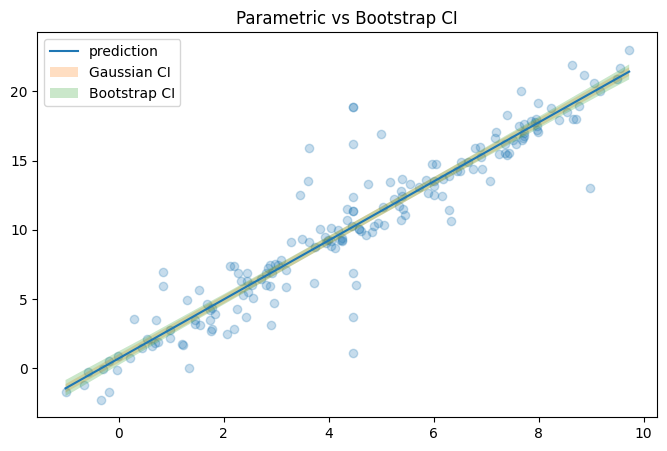

In [5]:
resid = y - y_hat
sigma_hat = np.std(resid, ddof=1)
n = len(y)
se_mean = sigma_hat/np.sqrt(n)
x_grid = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 120).reshape(-1,1)
pred_line = model.predict(x_grid)
gauss_lo = pred_line - 1.96*se_mean
gauss_hi = pred_line + 1.96*se_mean

def bootstrap_predictions(X, y, x_grid, n_boot=500, seed=111):
    rng = np.random.default_rng(seed)
    preds = []
    idx = np.arange(len(y))
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        m = fit_fn(X[b].reshape(-1,1), y[b])
        preds.append(m.predict(x_grid))
    P = np.vstack(preds)
    return P.mean(axis=0), np.percentile(P, 2.5, axis=0), np.percentile(P, 97.5, axis=0)

m_boot, lo_boot, hi_boot = bootstrap_predictions(X_base, y, x_grid, n_boot=600)

plt.figure()
plt.scatter(X_base, y, alpha=0.25)
plt.plot(x_grid, pred_line, label='prediction')
plt.fill_between(x_grid.ravel(), gauss_lo, gauss_hi, alpha=0.25, label='Gaussian CI')
plt.fill_between(x_grid.ravel(), lo_boot, hi_boot, alpha=0.25, label='Bootstrap CI')
plt.legend(); plt.title('Parametric vs Bootstrap CI'); plt.show()

## Scenario Sensitivity (Required): Choose ≥2 Scenarios
Examples: mean vs median impute; drop; alternate feature transform

In [6]:
scenarios = {
    'mean_impute': mean_impute,
    'median_impute': median_impute,
    'drop_missing': lambda a: a[~np.isnan(a)] if np.isnan(a).any() else a
}

results = []
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xs, ys = X_raw[mask], y[mask]
        m = fit_fn(Xs.reshape(-1,1), ys)
        yh = m.predict(Xs.reshape(-1,1))
    else:
        Xs = fn(X_raw)
        m = fit_fn(Xs.reshape(-1,1), y)
        yh = m.predict(Xs.reshape(-1,1))
    results.append({'scenario': name, 'mae': mae(y[:len(yh)], yh), 'slope': m.coef_[0], 'intercept': m.intercept_})
sens = pd.DataFrame(results); sens

,scenario,mae,slope,intercept
0,mean_impute,1.278317,2.130236,0.711523
1,median_impute,1.283954,2.129290,0.727146
2,drop_missing,2.061050,2.130236,0.659164


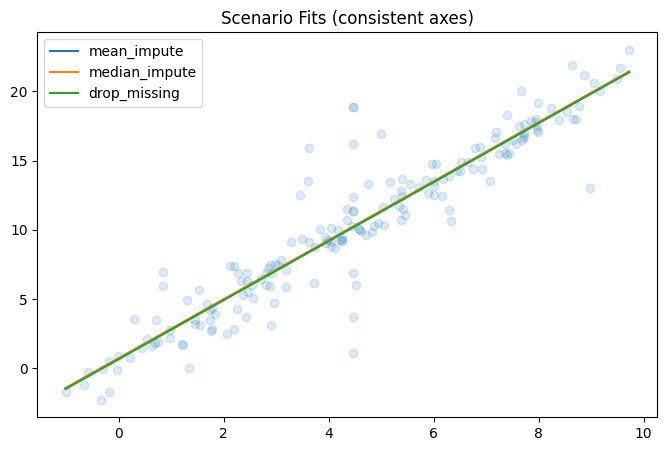

In [7]:
plt.figure()
xg = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 150).reshape(-1,1)
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xi, yi = X_raw[mask], y[mask]
    else:
        Xi, yi = fn(X_raw), y
    m = fit_fn(Xi.reshape(-1,1), yi)
    plt.plot(xg, m.predict(xg), label=name)
plt.scatter(X_base, y, alpha=0.15)
plt.title('Scenario Fits (consistent axes)'); plt.legend(); plt.show()

## Subgroup Diagnostic (Required)

In [8]:
model_base = fit_fn(X_base.reshape(-1,1), y)
df2 = df.copy()
df2['y_hat'] = model_base.predict(df2['x_imputed'].values.reshape(-1,1))
df2['resid'] = df2['y_target'] - df2['y_hat']
g = df2.groupby('segment')['resid'].agg(['mean','std','median','count'])
g

,mean,std,median,count
segment,,,,
A,-0.066306,1.827501,-0.235648,94
B,0.294967,1.707514,-0.077390,41
C,-0.130242,2.813215,-0.140354,45


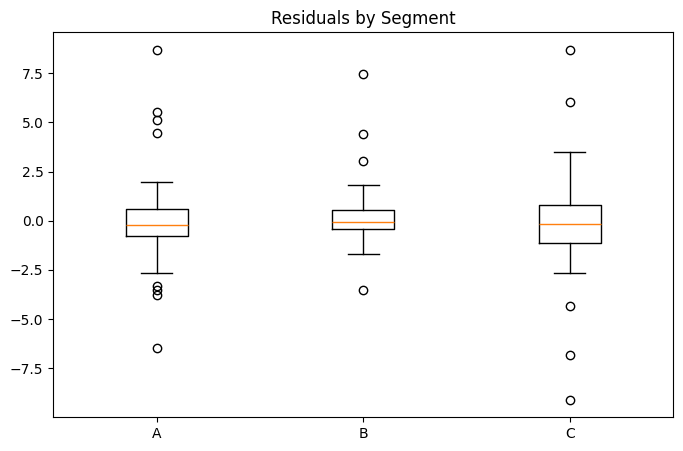

In [9]:
plt.figure()
grouped = df2.groupby('segment')['resid']
data = [s.values for _, s in grouped]
labels = list(grouped.groups.keys())

plt.boxplot(data, tick_labels=labels)
plt.title('Residuals by Segment')
plt.show()


## Bootstrap a Metric (Required)

In [10]:
bm = bootstrap_metric(y, df2['y_hat'].values, mae, n_boot=600)
bm

{'mean': 1.2714062440720513,
 'lo': 1.0550822262814061,
 'hi': 1.5309979723635574}

## Stakeholder Summary (Required — ≤ 1 page)
- Key assumptions: The key assumption is that the number of data is large enough for the central limit theorem and that the data is normally distributied and not skewed. However, the plot shows that the gaussian CI is narrowrer and therefore more confident than the bootstraped CI, showing skewedness in the distribution of data.
- Sensitivity results & takeaways: Senrio analysis shows similar results. Which means the missing data is probably not biased and we can just pick the most simple strategy to fill the missing data. Also, it shows that the model is robuse.
- Subgroup risks: The mean and n are more or less close to zero, reducing the risk of systematic bias. In some cases there  small value in mean or medina (about 0.3), so there are some outliers present. However, the std is large relative to the data, there is too much variation in the data and the prediction may be unstable.
- “Prediction holds if the data is normally distributed”, “Model is sensitive to outliers, as the data may be skwed. The mae increase when dropping the NAN data also indicates that it is sensitive to the number of data provided and reducing the database may casuse decreased accuracy.”